# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *
import mudata

/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-22 00:16:27,406	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

In [5]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr7:5699934-5700326,USP42,0.012186,0.073726,0.000898,0.000898,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.634026,1,0.306563,320921
1,chr17:50503685-50504463,SPAG9,0.016888,0.056999,0.000963,0.000963,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),6.348872,1,0.450471,99029
2,chr11:64554718-64555695,SF1,0.015742,0.106257,0.001673,0.001673,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.920586,1,0.339334,288238
3,chr19:12331638-12331965,ZNF44,0.029026,0.142447,0.004135,0.004135,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.265952,1,0.287137,259404
4,chr8:52531839-52532756,RB1CC1,0.033726,0.129425,0.004365,0.004365,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),2.366792,1,0.415303,163218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353568,chr19:3028015-3029354,GNA15,0.005503,-0.158408,-0.000872,0.000872,ZNF880,False,ZNF880_direct_-/-,ZNF880_direct_-/-_(115g),ZNF880_direct_-/-_(374r),1.443485,-1,-0.317678,225350
353569,chr12:26841152-26841356,INTS13,0.004896,-0.061075,-0.000299,0.000299,ZNF880,False,ZNF880_direct_-/-,ZNF880_direct_-/-_(115g),ZNF880_direct_-/-_(374r),0.317200,-1,-0.141209,353414
353570,chr19:17841818-17842412,JUND,0.011459,-0.332715,-0.003813,0.003813,ZNF880,False,ZNF880_direct_-/-,ZNF880_direct_-/-_(115g),ZNF880_direct_-/-_(374r),0.295562,-1,-0.273378,340873
353571,chr20:32945650-32946229,CDK5RAP1,0.042702,-0.117954,-0.005037,0.005037,ZNF880,False,ZNF880_direct_-/-,ZNF880_direct_-/-_(115g),ZNF880_direct_-/-_(374r),0.362353,-1,-0.039799,273951


In [6]:
scplus_mdata.uns["extended_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr1:31815685-31816223,PTP4A2,0.012690,0.382654,0.004856,0.004856,AHR,True,AHR_extended_+/+,AHR_extended_+/+_(18g),AHR_extended_+/+_(17r),1.251970,1,0.174498,93350
1,chr12:12716648-12717552,CDKN1B,0.050690,0.314615,0.015948,0.015948,AHR,True,AHR_extended_+/+,AHR_extended_+/+_(18g),AHR_extended_+/+_(17r),0.365566,1,0.194965,25658
2,chr18:26717089-26717614,TAF4B,0.027888,0.131448,0.003666,0.003666,AHR,True,AHR_extended_+/+,AHR_extended_+/+_(18g),AHR_extended_+/+_(17r),1.385337,1,0.182460,46974
3,chr10:60271392-60272040,CCDC6,0.040391,0.217906,0.008801,0.008801,AHR,True,AHR_extended_+/+,AHR_extended_+/+_(18g),AHR_extended_+/+_(17r),0.625863,1,0.152069,79285
4,chr3:157066794-157067552,CCNL1,0.038547,0.182494,0.007035,0.007035,AHR,True,AHR_extended_+/+,AHR_extended_+/+_(18g),AHR_extended_+/+_(17r),0.789365,1,0.201062,47185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160516,chr3:184636530-184638031,POLR2H,0.001144,-0.110585,-0.000126,0.000126,ZNF91,True,ZNF91_extended_-/-,ZNF91_extended_-/-_(59g),ZNF91_extended_-/-_(57r),0.124268,-1,-0.219032,125539
160517,chr8:89765769-89766132,RIPK2,0.005950,-0.212119,-0.001262,0.001262,ZNF91,True,ZNF91_extended_-/-,ZNF91_extended_-/-_(59g),ZNF91_extended_-/-_(57r),0.682805,-1,-0.302109,144947
160518,chr10:99776853-99777559,GOT1,0.044209,-0.167873,-0.007421,0.007421,ZNF91,True,ZNF91_extended_-/-,ZNF91_extended_-/-_(59g),ZNF91_extended_-/-_(57r),0.236053,-1,-0.065470,84116
160519,chrM:0-3919,MT-ND4L,0.532350,-0.106002,-0.056430,0.056430,ZNF91,True,ZNF91_extended_-/-,ZNF91_extended_-/-_(59g),ZNF91_extended_-/-_(57r),0.296499,-1,-0.119206,118


In [7]:
scplus_mdata

MuData object with n_obs × n_vars = 18835 × 200772
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	18835 x 33538
      obs:	'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'
    scATAC_counts:	18835 x 164762
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'predicted.t.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.m.traj.ptime', 'predicted.celltype_refmap.score', 'predicted.celltype_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.trajectory.score', 'predicted.trajectory'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	18835 x 733
    direct_region_based_AUC:	18835 x 733
    extended_gene_based_AUC:	18835 x 503
    extended_region_based_AUC:	18835 x 503

In [8]:
apply_std_filtering_to_eRegulons(scplus_mdata)

2024-11-16 12:00:16,130 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-16 12:00:16,167 Preprocessing INFO     Only keep extended inf not direct


In [9]:
scplus_mdata.uns['e_regulon_metadata_filtered']

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr7:5699934-5700326,USP42,0.012186,0.073726,0.000898,0.000898,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.634026,1,0.306563,320921
1,chr17:50503685-50504463,SPAG9,0.016888,0.056999,0.000963,0.000963,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),6.348872,1,0.450471,99029
2,chr11:64554718-64555695,SF1,0.015742,0.106257,0.001673,0.001673,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.920586,1,0.339334,288238
3,chr19:12331638-12331965,ZNF44,0.029026,0.142447,0.004135,0.004135,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),1.265952,1,0.287137,259404
4,chr8:52531839-52532756,RB1CC1,0.033726,0.129425,0.004365,0.004365,AFF4,False,AFF4_direct_+/+,AFF4_direct_+/+_(285g),AFF4_direct_+/+_(764r),2.366792,1,0.415303,163218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129339,chr9:136655300-136656331,EGFL7,0.044794,0.546889,0.024497,0.024497,ZNF107,True,ZNF107_extended_-/+,ZNF107_extended_-/+_(22g),ZNF107_extended_-/+_(24r),0.221645,-1,-0.295921,38243
129340,chr16:881514-881768,NME4,0.026161,0.056373,0.001475,0.001475,ZNF107,True,ZNF107_extended_-/+,ZNF107_extended_-/+_(22g),ZNF107_extended_-/+_(24r),0.371168,-1,-0.184992,100970
129341,chr11:36149413-36150230,LDLRAD3,0.014093,0.131003,0.001846,0.001846,ZNF107,True,ZNF107_extended_-/+,ZNF107_extended_-/+_(22g),ZNF107_extended_-/+_(24r),0.130537,-1,-0.036360,127307
129342,chr13:112892652-112894654,LAMP1,0.004425,0.167310,0.000740,0.000740,ZNF107,True,ZNF107_extended_-/+,ZNF107_extended_-/+_(22g),ZNF107_extended_-/+_(24r),0.203776,-1,-0.175004,128557


In [10]:
scplus_mdata.uns['e_regulon_metadata_filtered'].to_csv(out_dir+'eRegulon_filtered.tsv', sep='\t', index=False)

In [11]:
eRegulon_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"], 
    scplus_mdata["direct_region_based_AUC"], scplus_mdata["extended_region_based_AUC"]],
    axis = 1,
)
eRegulon_AUC.obs = scplus_mdata.obs.loc[eRegulon_AUC.obs_names]

In [12]:
eRegulon_AUC.write(out_dir+'eGRN_AUC.h5ad')

In [ ]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scATAC_counts:annotation",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (23, 5)
)

# In Silico Perturbation

In [3]:
from scenicplus.simulation import (
    train_gene_expression_models,
    simulate_perturbation,
    plot_perturbation_effect_in_embedding
)
import adjustText
from matplotlib.cm import get_cmap

In [4]:
def plot_scenic_umap(ax):
    texts = []
    unique_trajectories = set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"])
    cmap = get_cmap("tab10")  # Replace "tab10" with another colormap name if desired
    color_list = [cmap(i) for i in range(len(unique_trajectories))]
    color_dict = dict(zip(unique_trajectories, color_list))
    
    # Plot UMAP
    ax.scatter(
        eRegulon_gene_AUC.obsm["X_umap"][:, 0],
        eRegulon_gene_AUC.obsm["X_umap"][:, 1],
        color=[color_dict[line] for line in eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]]
    )
    # Plot labels
    for line in set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]):
        line_bc_idc = np.arange(len(eRegulon_gene_AUC.obs_names))[eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"] == line]
        avg_x, avg_y = eRegulon_gene_AUC.obsm["X_umap"][line_bc_idc, 0:2].mean(0)
        texts.append(
            ax.text(
                avg_x,
                avg_y,
                line,
                fontweight = "bold"
            )
        )
    adjustText.adjust_text(texts)


In [5]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

apply_std_filtering_to_eRegulons(scplus_mdata)

eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)
eRegulon_gene_AUC.obs = scplus_mdata.obs

2024-11-22 00:17:31,480 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-22 00:17:31,514 Preprocessing INFO     Only keep extended inf not direct


In [6]:
gene_tf_direct_extended = pd.concat(
    [
        scplus_mdata.uns["direct_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates(),
        scplus_mdata.uns["extended_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates()
    ]
).drop_duplicates()
gene_to_TF = gene_tf_direct_extended.groupby("Gene")["TF"].apply(lambda tfs: list(tfs)).to_dict()

In [7]:
umap = pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/TALL_metacells_refUMAP.csv')
umap.set_index('Unnamed: 0', inplace=True)
umap.index = umap.index + '___cisTopic'
umap.index.name = None

missing_indices = set(scplus_mdata.obs.index) - set(umap.index)
if missing_indices:
    print("The following indices are missing in 'umap':")
    print(missing_indices)
else:
    # Reorder umap to match scplus_mdata.obs.index
    umap = umap.loc[scplus_mdata.obs.index]


# set pca and umap
eRegulon_gene_AUC.obsm['X_umap'] = umap.to_numpy()

In [8]:
#regressors = pickle.load(open(out_dir + 'TALL_InSilico_Regressors.pkl', 'rb'))

In [8]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA9_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA5_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA3_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/JUNB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_JUNB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/FOSB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_FOSB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_CEBPA_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")


Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA9_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA5_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_HOXA3_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_JUNB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_FOSB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/TALL_CEBPA_perturbation_iter_11_processed.tsv.


2024-11-19 22:50:03,015 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:50:50,489 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:52:19,301 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 23:52:34,573 Perturbation INFO     Calculating grid of arrows
2024-11-19 23:52:34,650 Perturbation INFO     Plotting


<AxesSubplot: >

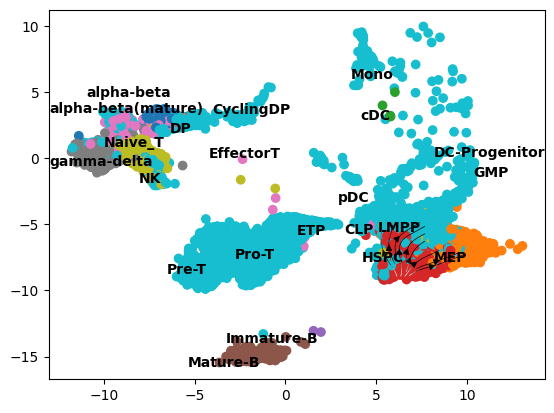

In [10]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-22 01:45:22,753 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-22 01:46:08,967 Perturbation INFO     Scoring eRegulons.
2024-11-22 01:47:33,348 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-22 02:57:22,588 Perturbation INFO     Calculating grid of arrows
2024-11-22 02:57:22,667 Perturbation INFO     Plotting


<AxesSubplot: >

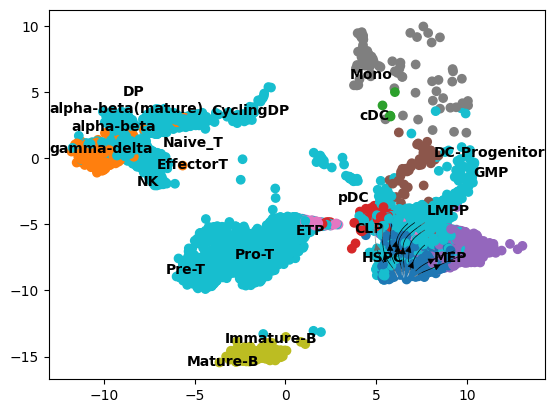

In [9]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-22 02:59:06,463 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-22 02:59:49,148 Perturbation INFO     Scoring eRegulons.
2024-11-22 03:01:20,709 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-22 03:57:34,236 Perturbation INFO     Calculating grid of arrows
2024-11-22 03:57:34,313 Perturbation INFO     Plotting


<AxesSubplot: >

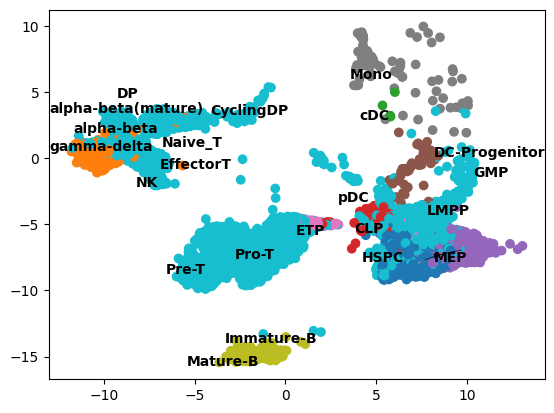

In [10]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-22 03:58:57,181 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-22 03:59:39,165 Perturbation INFO     Scoring eRegulons.
2024-11-22 04:00:45,245 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-22 05:06:55,369 Perturbation INFO     Calculating grid of arrows
2024-11-22 05:06:55,469 Perturbation INFO     Plotting


<AxesSubplot: >

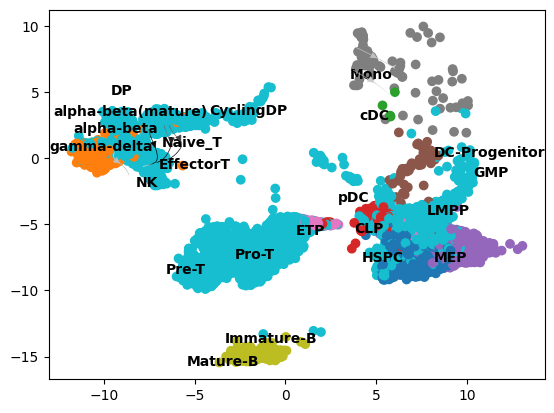

In [11]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/FOSB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-22 05:08:34,611 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-22 05:09:15,689 Perturbation INFO     Scoring eRegulons.
2024-11-22 05:10:21,839 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-22 06:06:01,584 Perturbation INFO     Calculating grid of arrows
2024-11-22 06:06:01,661 Perturbation INFO     Plotting


<AxesSubplot: >

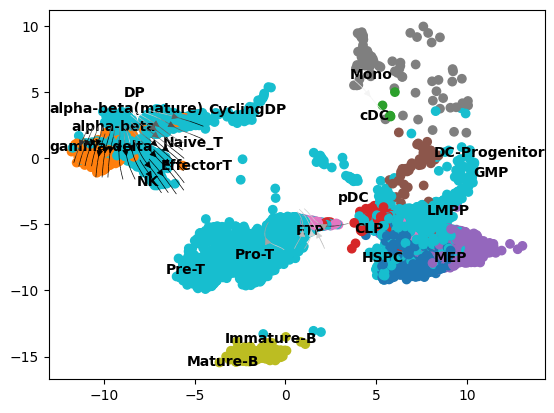

In [12]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/JUNB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-22 06:08:02,667 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-22 06:08:40,671 Perturbation INFO     Scoring eRegulons.
2024-11-22 06:09:41,804 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-22 07:01:41,403 Perturbation INFO     Calculating grid of arrows
2024-11-22 07:01:41,478 Perturbation INFO     Plotting


<AxesSubplot: >

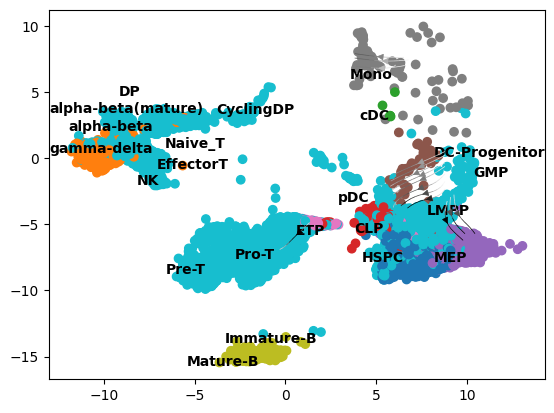

In [13]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/T_ALL/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

Individual Gene Perturbations

In [ ]:
genes_to_show = ["HOXA10", "SPINK2", "ANXA1", "CD44", "LYL1", "CD34", "SERPINB1", "EGFL7", "IRF1", "FOS"]
cell_type = "Progenitor"
fig, ax = plt.subplots()
baseline = perturbation_over_iter[0].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, genes_to_show]
for gene in genes_to_show:
    ax.plot(
        np.arange(10) + 1,
        [
            np.log2(perturbation_over_iter[i].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, gene] / baseline[gene])
            for i in np.arange(10) + 1
        ],
        label = gene
    )
ax.set_ylabel("Predicted $log{_2}FC$")
ax.set_xlabel("Iteration")
ax.legend()
ax.axhline(y = 0, color = "black")
ax.grid("gray")
ax.set_axisbelow(True)